# Software Requirements Classification
## Best model selection

### Data Preprocessing

In [192]:
import pandas as pd

df = pd.read_csv('software_requirements_extended.csv') # Load the dataset
df.head() # Display the first 5 rows to check the data

,Type,Requirement
0,PE,The system shall refresh the display every 60 ...
1,LF,The application shall match the color of the s...
2,US,If projected the data must be readable. On ...
3,A,The product shall be available during normal ...
4,US,If projected the data must be understandable...


In [193]:
df.info() # Check the data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Type         977 non-null    object
 1   Requirement  977 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


In [194]:
import plotly.express as px

# draw a pie chart of the different sentiments of the posts to see the distribution of the data
fig = px.pie(df, names='Type', title ='Pie of types of requirements')
fig.show()

As we can see, we have small data set with many classes. It may be difficult to classify the data with such small data set and many classes. So we will merge the classes to two classes only. 

In [195]:
df['Type'] = df['Type'].apply(lambda x: 1 if x == 'FR' or x == 'F' else 0) # Merge the classes to two classes only
fig = px.pie(df, names='Type', title ='Pie of types of requirements')  # Display it again
fig.show()

Now we can see that the data is balanced.

In [196]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to preprocess text and generate word cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


Word Cloud for Functional Requirements


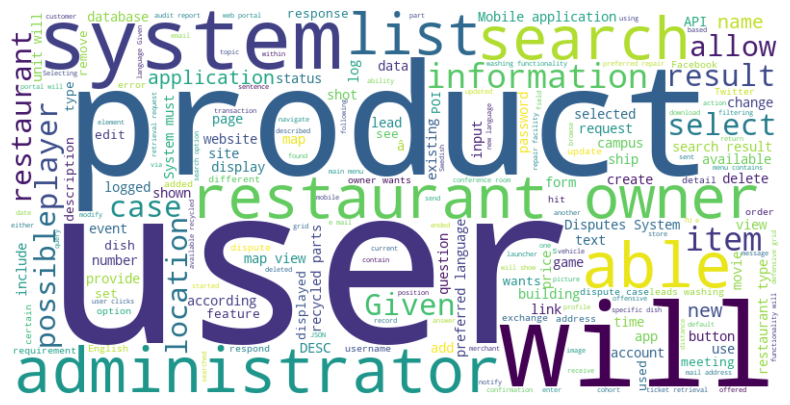

Word Cloud for Non-Functional Requirements


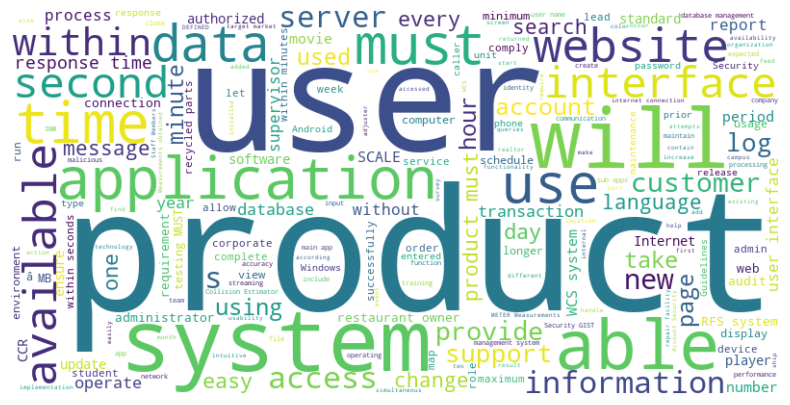

In [197]:
# Separate the requirements by type
functional_requirements = ' '.join(df[df['Type'] == 1]['Requirement'])
non_functional_requirements = ' '.join(df[df['Type'] == 0]['Requirement'])

# Generate and display word clouds
print("Word Cloud for Functional Requirements")
generate_wordcloud(functional_requirements)

print("Word Cloud for Non-Functional Requirements")
generate_wordcloud(non_functional_requirements)

In [198]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Create function to clean the text. With stemming or lemmatization

In [199]:
# Pre-load stopwords to improve efficiency
STOPWORDS = set(stopwords.words("english"))

# Expanded pattern to potentially keep useful punctuation or additional cleaning
pattern = re.compile(r"[^a-zA-Z]")

def req_to_words(req, lemmatize=True):
    """Convert requirement text into a sequence of words after lemmatization."""
    # Convert to lower case
    text = req.lower()
    # Remove unwanted characters
    text = re.sub(pattern, " ", text)
    # Tokenize
    words = text.split()
    # Remove stopwords
    words = [w for w in words if w not in STOPWORDS]
    if lemmatize:
        # Apply lemmatization
        words = [ WordNetLemmatizer().lemmatize(w) for w in words]
    else:
        # Apply stemming
        words = [PorterStemmer().stem(w) for w in words]
    return words

# Example use
print("\nOriginal requirement ->", df['Requirement'][0])
print("\nProcessed requirement ->", req_to_words(df['Requirement'][0]))
print("\nProcessed requirement ->", req_to_words(df['Requirement'][0], lemmatize=False))


Original requirement -> The system shall refresh the display every 60 seconds.

Processed requirement -> ['system', 'shall', 'refresh', 'display', 'every', 'second']

Processed requirement -> ['system', 'shall', 'refresh', 'display', 'everi', 'second']


### Models
Now we will create different models with best hyperparameters (got earlier) and compare them.

#### Logistic Regression

In [200]:
from sklearn.linear_model import LogisticRegression

logR = LogisticRegression(
    C=10,  # Regularization strength
    penalty='l2',  # Norm used in the penalization
    solver='saga',  # Optimization algorithm
    max_iter=200  # Maximum number of iterations for the optimization algorithm
)

#### KNN

In [201]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    metric='euclidean',
    n_neighbors=1,
    weights='uniform'
)

#### Naive Bayes

In [202]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(
    alpha=0.1
)

#### SVC

In [203]:
from sklearn.svm import SVC

svc = SVC(
    C=10, 
    gamma=1, 
    kernel='rbf',
    probability=True
)

#### Decision Tree

In [204]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=10
)

#### Decision Tree with AdaBoost

In [205]:
from sklearn.ensemble import AdaBoostClassifier

ada_dtc = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        criterion='gini',
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=10
    ),
    n_estimators=100,
    learning_rate=2
)

#### Hard Voting

In [206]:
from sklearn.ensemble import VotingClassifier

voting_clf_hard = VotingClassifier(
    estimators=[('lr', logR), ('svc', svc), ('dt', dtc), ('nb', nb), ('knn', knn), ('ada', ada_dtc)],
    voting='hard'
)

#### Soft Voting

In [207]:
voting_clf_soft = VotingClassifier(
    estimators=[('lr', logR), ('svc', svc), ('dt', dtc), ('nb', nb), ('knn', knn), ('ada', ada_dtc)],
    voting='soft'
)

### Testing

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def run_model_evaluation(model, X, y, n, lemmatize=True):
    """
    Evaluate a model by splitting the data n times into training and testing sets,
    fitting the model, and calculating the accuracy in percent.
    
    Parameters:
    - model: The machine learning model to be evaluated.
    - X: The input features (text data).
    - y: The target labels.
    - n: The number of times to repeat the process.
    - lemmatize: Boolean flag indicating whether to use lemmatization (True) or stemming (False).
    
    Returns:
    - accuracies: An array of accuracy scores (in percent) from each iteration.
    """
    accuracies = []

    for _ in range(n):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

        # Preprocess and vectorize the text
        vectorizer = TfidfVectorizer(analyzer=lambda x: req_to_words(x, lemmatize=lemmatize))
        X_train_vectorized = vectorizer.fit_transform(X_train)
        X_test_vectorized = vectorizer.transform(X_test)

        # Fit the model
        model.fit(X_train_vectorized, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_vectorized)
        accuracy = accuracy_score(y_test, y_pred) * 100  # Convert accuracy to percent
        accuracies.append(accuracy)

    return accuracies

In [209]:
X = df['Requirement']
y = df['Type']
n = 10  # Number of iterations

In [210]:
# Logistic Regression
logR_accuracies_l = run_model_evaluation(logR, X, y, n, lemmatize=True) # Lemmatization
logR_accuracies_s = run_model_evaluation(logR, X, y, n, lemmatize=False) # Stemming
print("Logistic Regression (lemmatization):", np.mean(logR_accuracies_l), "%")
print("Logistic Regression (stemming):", np.mean(logR_accuracies_s), "%")

Logistic Regression (lemmatization): 88.06122448979592 %
Logistic Regression (stemming): 87.41496598639455 %


In [211]:
# KNN
knn_accuracies_l = run_model_evaluation(knn, X, y, n, lemmatize=True) # Lemmatization
knn_accuracies_s = run_model_evaluation(knn, X, y, n, lemmatize=False) # Stemming
print("KNN (lemmatization):", np.mean(knn_accuracies_l), "%")
print("KNN (stemming):", np.mean(knn_accuracies_s), "%")

KNN (lemmatization): 84.08163265306122 %
KNN (stemming): 82.99319727891157 %


In [212]:
# Naive Bayes
nb_accuracies_l = run_model_evaluation(nb, X, y, n, lemmatize=True) # Lemmatization
nb_accuracies_s = run_model_evaluation(nb, X, y, n, lemmatize=False) # Stemming
print("Naive Bayes (lemmatization):", np.mean(nb_accuracies_l), "%")
print("Naive Bayes (stemming):", np.mean(nb_accuracies_s), "%")

Naive Bayes (lemmatization): 86.93877551020407 %
Naive Bayes (stemming): 87.10884353741497 %


In [213]:
# SVC
svc_accuracies_l = run_model_evaluation(svc, X, y, n, lemmatize=True) # Lemmatization
svc_accuracies_s = run_model_evaluation(svc, X, y, n, lemmatize=False) # Stemming
print("SVC (lemmatization):", np.mean(svc_accuracies_l), "%")
print("SVC (stemming):", np.mean(svc_accuracies_s), "%")

SVC (lemmatization): 88.77551020408164 %
SVC (stemming): 87.55102040816327 %


In [214]:
# Decision Tree
dtc_accuracies_l = run_model_evaluation(dtc, X, y, n, lemmatize=True) # Lemmatization
dtc_accuracies_s = run_model_evaluation(dtc, X, y, n, lemmatize=False) # Stemming
print("Decision Tree (lemmatization):", np.mean(dtc_accuracies_l), "%")
print("Decision Tree (stemming):", np.mean(dtc_accuracies_s), "%")

Decision Tree (lemmatization): 79.21768707482993 %
Decision Tree (stemming): 79.79591836734694 %


In [215]:
# Decision Tree with AdaBoost
ada_dtc_accuracies_l = run_model_evaluation(ada_dtc, X, y, n, lemmatize=True) # Lemmatization
ada_dtc_accuracies_s = run_model_evaluation(ada_dtc, X, y, n, lemmatize=False) # Stemming
print("Decision Tree with AdaBoost (lemmatization):", np.mean(ada_dtc_accuracies_l), "%")
print("Decision Tree with AdaBoost (stemming):", np.mean(ada_dtc_accuracies_s), "%")

Decision Tree with AdaBoost (lemmatization): 83.80952380952381 %
Decision Tree with AdaBoost (stemming): 82.31292517006803 %


In [216]:
# Hard Voting
voting_clf_hard_accuracies_l = run_model_evaluation(voting_clf_hard, X, y, n, lemmatize=True) # Lemmatization
voting_clf_hard_accuracies_s = run_model_evaluation(voting_clf_hard, X, y, n, lemmatize=False) # Stemming
print("Hard Voting (lemmatization):", np.mean(voting_clf_hard_accuracies_l), "%")
print("Hard Voting (stemming):", np.mean(voting_clf_hard_accuracies_s), "%")

Hard Voting (lemmatization): 89.38775510204081 %
Hard Voting (stemming): 88.26530612244899 %


In [217]:
# Soft Voting
voting_clf_soft_accuracies_l = run_model_evaluation(voting_clf_soft, X, y, n, lemmatize=True) # Lemmatization
voting_clf_soft_accuracies_s = run_model_evaluation(voting_clf_soft, X, y, n, lemmatize=False) # Stemming
print("Soft Voting (lemmatization):", np.mean(voting_clf_soft_accuracies_l), "%")
print("Soft Voting (stemming):", np.mean(voting_clf_soft_accuracies_s), "%")

Soft Voting (lemmatization): 88.9795918367347 %
Soft Voting (stemming): 88.23129251700679 %


In [218]:
import matplotlib.pyplot as plt

def plot_accuracy_over_runs(n_runs, accuracies_lemmatization, accuracies_stemming, models):
    """
    Plot two graphs showing the accuracy of each model over n runs, 
    one for lemmatization and one for stemming.
    
    Parameters:
    - n_runs: List or array of run numbers (e.g., [1, 2, ..., n]).
    - accuracies_lemmatization: Dictionary with model names as keys and lists of accuracies using lemmatization as values.
    - accuracies_stemming: Dictionary with model names as keys and lists of accuracies using stemming as values.
    - models: List of model names.
    """
    fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

    # Plot accuracies for lemmatization
    for model in models:
        axs[0].plot(n_runs, accuracies_lemmatization[model], '-o', label=model)
    axs[0].set_title('Model Accuracies with Lemmatization Over Runs')
    axs[0].set_ylabel('Accuracy (%)')
    axs[0].legend()

    # Plot accuracies for stemming
    for model in models:
        axs[1].plot(n_runs, accuracies_stemming[model], '-o', label=model)
    axs[1].set_title('Model Accuracies with Stemming Over Runs')
    axs[1].set_xlabel('Run Number')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [219]:
# Prepare the data for plotting
n_runs = list(range(1, n + 1))  # Create a list of runs for the x-axis
models = ['LogR', 'KNN', 'NB', 'SVC', 'DTC', 'AdaBoost', 'Hard Voting', 'Soft Voting']  # List your models

# Accuracies with lemmatization
accuracies_lemmatization = {
    'LogR': logR_accuracies_l,
    'KNN': knn_accuracies_l,
    'NB': nb_accuracies_l,
    'SVC': svc_accuracies_l,
    'DTC': dtc_accuracies_l,
    'AdaBoost': ada_dtc_accuracies_l,
    'Hard Voting': voting_clf_hard_accuracies_l,
    'Soft Voting': voting_clf_soft_accuracies_l
}

# Accuracies with stemming
accuracies_stemming = {
    'LogR': logR_accuracies_s,
    'KNN': knn_accuracies_s,
    'NB': nb_accuracies_s,
    'SVC': svc_accuracies_s,
    'DTC': dtc_accuracies_s,
    'AdaBoost': ada_dtc_accuracies_s,
    'Hard Voting': voting_clf_hard_accuracies_s,
    'Soft Voting': voting_clf_soft_accuracies_s
}

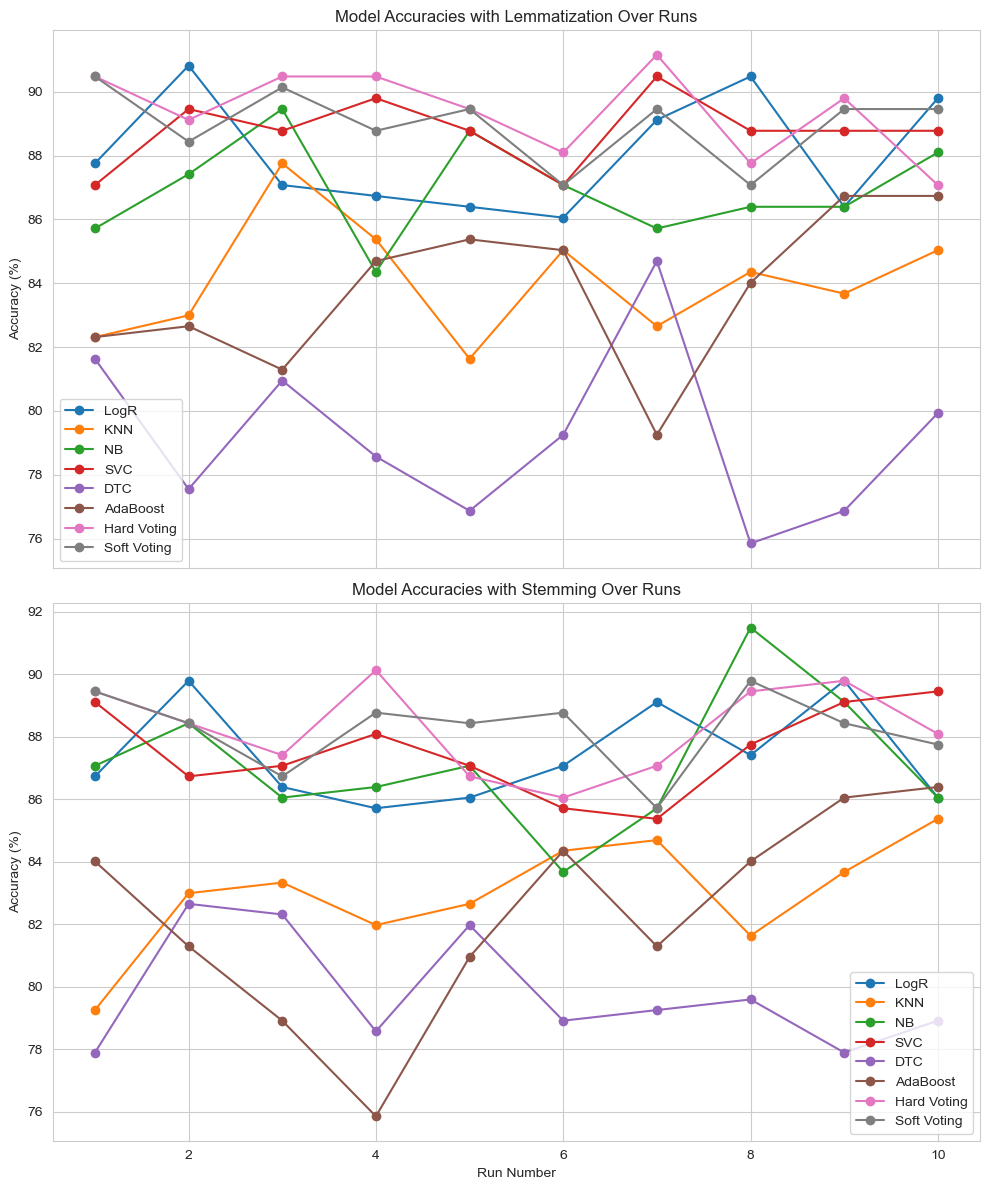

In [220]:
plot_accuracy_over_runs(n_runs, accuracies_lemmatization, accuracies_stemming, models)

In [233]:
def plot_mean_accuracies_and_best_model(accuracies_lemmatization, accuracies_stemming, models):
    """
    Plot a graph of the mean accuracies for all models and both preprocessing techniques,
    and annotate the best model with the best preprocessing technique.
    
    Parameters:
    - accuracies_lemmatization: Dictionary with model names as keys and lists of accuracies using lemmatization as values.
    - accuracies_stemming: Dictionary with model names as keys and lists of accuracies using stemming as values.
    - models: List of model names.
    
    Returns:
    - best_model: A tuple containing the name of the best model and its best preprocessing technique.
    """
    # Calculate mean accuracies
    means_lemmatization = {model: np.mean(acc) for model, acc in accuracies_lemmatization.items()}
    means_stemming = {model: np.mean(acc) for model, acc in accuracies_stemming.items()}

    # Determine the best model and preprocessing technique
    best_model, best_score, best_preprocessing = max(
        [(model, means_lemmatization[model], 'Lemmatization') for model in models] +
        [(model, means_stemming[model], 'Stemming') for model in models],
        key=lambda x: x[1]
    )

    # Plot the mean accuracies
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(models))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(x - width/2, means_lemmatization.values(), width, label='Lemmatization')
    rects2 = ax.bar(x + width/2, means_stemming.values(), width, label='Stemming')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean Accuracy (%)')
    ax.set_title('Mean Accuracy by Model and Preprocessing Technique')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend(loc='lower center')

    # Annotate
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


    plt.tight_layout()
    plt.show()

    return best_model, best_preprocessing

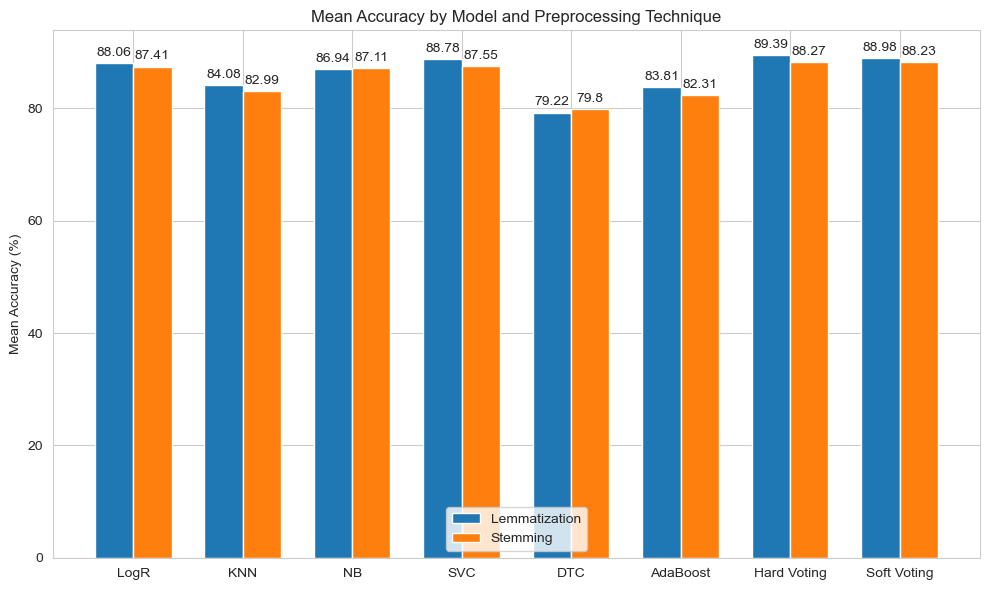

The best model is Hard Voting with Lemmatization.


In [234]:
best_model_name, best_preprocess = plot_mean_accuracies_and_best_model(accuracies_lemmatization, accuracies_stemming, models)
print(f"The best model is {best_model_name} with {best_preprocess}.")

### Best Model Tests
Based on the previous results, we will use the best model to test it on some examples not from dataset.

In [223]:
isLemmatize = best_preprocess == 'Lemmatization'
y = df['Type'] # Target
X = [' '.join(req_to_words(req,lemmatize=isLemmatize)) for req in df['Requirement']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [224]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [225]:
best_model = None
if best_model_name == 'LogR':
    best_model = logR
elif best_model_name == 'KNN':
    best_model = knn
elif best_model_name == 'NB':
    best_model = nb
elif best_model_name == 'SVC':
    best_model = svc
elif best_model_name == 'DTC':
    best_model = dtc
elif best_model_name == 'AdaBoost':
    best_model = ada_dtc
elif best_model_name == 'Hard Voting':
    best_model = voting_clf_hard
elif best_model_name == 'Soft Voting':
    best_model = voting_clf_soft

best_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, max_iter=200,
                                                 solver='saga')),
                             ('svc', SVC(C=10, gamma=1, probability=True)),
                             ('dt',
                              DecisionTreeClassifier(min_samples_split=10)),
                             ('nb', MultinomialNB(alpha=0.1)),
                             ('knn',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=1)),
                             ('ada',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(min_samples_split=10),
                                                 learning_rate=2,
                                                 n_estimators=100))])

In [226]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test,y_pred) * 100:.2f}%')
print(classification_report(y_test, y_pred))

Accuracy: 90.48%
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       131
           1       0.94      0.89      0.91       163

    accuracy                           0.90       294
   macro avg       0.90      0.91      0.90       294
weighted avg       0.91      0.90      0.90       294


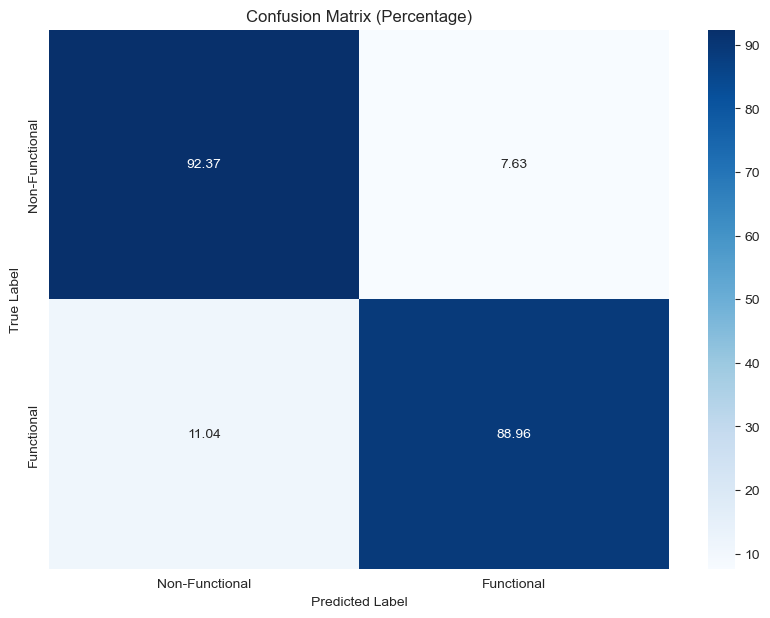

In [227]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Convert to percentage
cm_percentage = cm_normalized * 100

# Visualize the confusion matrix as percentages
plt.figure(figsize=(10,7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Functional', 'Functional'], yticklabels=['Non-Functional', 'Functional'])
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [228]:
def predict_req(req, expected, model, vectorizer):
    df = pd.DataFrame([req], columns=['Requirement'])
    X = [' '.join(req_to_words(req)) for req in df['Requirement']]
    X = vectorizer.transform(X)

    prediction = model.predict(X)
    predicted_label = 'Functional' if prediction[0] == 1 else 'Non-Functional'
    success = predicted_label == expected

    return predicted_label, success


In [229]:
def summarize_predictions(examples, model, vectorizer):
    results = []
    for req, expected_label in examples:
        predicted_label, success = predict_req(req, expected_label, model, vectorizer)
        results.append({
            'Requirement': req,
            'Expected Label': expected_label,
            'Predicted Label': predicted_label,
            'Success': success
        })
    return pd.DataFrame(results)

In [230]:
examples = [
    ("The system shall provide a login form that accepts a username and password.", 'Functional'),
    ("The application must ensure that response times are less than 2 seconds under normal load conditions.", 'Non-Functional'),
    ("All user passwords shall be encrypted before saving to the database.", 'Functional'),
    ("The software should be compatible with the Windows 10 operating system.", 'Non-Functional'),
    ("The interface shall refresh when new data is available.", 'Functional'),
    ("The product shall comply with international accessibility standards.", 'Non-Functional'),
    ("Database backup shall occur every 24 hours automatically.", 'Functional'),
    ("The system shall support a minimum of 500 concurrent user connections.", 'Functional'),
    ("The system’s mean time to failure shall be at least 10,000 hours.", 'Non-Functional'),
    ("Users must be able to complete the primary workflow in less than three minutes.", 'Non-Functional'),
    ("User settings must be retained for at least one year without login.", 'Non-Functional'),
    ("The system must support multi-language interfaces.", 'Functional'),
    ("Ensure data integrity during transaction processing.", 'Functional'),
    ("The application should load the user dashboard within 3 seconds.", 'Non-Functional'),
    ("Support data export to CSV and PDF formats.", 'Functional'),
    ("Must be compatible with both iOS and Android operating systems.", 'Non-Functional'),
    ("Implement two-factor authentication for user logins.", 'Functional'),
    ("The application must be available 99.9% of the time.", 'Non-Functional'),
    ("Automatically log out users after 30 minutes of inactivity.", 'Functional'),
    ("The system must scale to support up to 10,000 users simultaneously.", 'Non-Functional'),
    ("Provide a way to recover forgotten passwords securely.", 'Functional'),
    ("The system must encrypt sensitive data both at rest and in transit.", 'Non-Functional'),
    ("Support for user roles including admin, editor, and viewer.", 'Functional'),
    ("Ensure the application interface adheres to the latest web accessibility guidelines.", 'Non-Functional'),
    ("The software must be installable on both Windows and MacOS.", 'Non-Functional'),
    ("Offer a search function that returns results within 2 seconds.", 'Functional'),
    ("The mobile app should use no more than 50MB of data per hour of activity.", 'Non-Functional'),
    ("The platform must integrate seamlessly with third-party email services.", 'Functional'),
    ("User feedback must be addressed and incorporated within two release cycles.", 'Non-Functional'),
    ("Provide detailed logging of user actions to support auditing requirements.", 'Functional')
]


In [231]:
summary = summarize_predictions(examples, best_model, vectorizer)
summary

,Requirement,Expected Label,Predicted Label,Success
0,The system shall provide a login form that acc...,Functional,Functional,True
1,The application must ensure that response time...,Non-Functional,Non-Functional,True
2,All user passwords shall be encrypted before s...,Functional,Non-Functional,False
3,The software should be compatible with the Win...,Non-Functional,Non-Functional,True
4,The interface shall refresh when new data is a...,Functional,Non-Functional,False
5,The product shall comply with international ac...,Non-Functional,Non-Functional,True
6,Database backup shall occur every 24 hours aut...,Functional,Non-Functional,False
7,The system shall support a minimum of 500 conc...,Functional,Non-Functional,False
8,The system’s mean time to failure shall be at ...,Non-Functional,Non-Functional,True
9,Users must be able to complete the primary wor...,Non-Functional,Non-Functional,True


In [232]:
import plotly.express as px

fig = px.pie(summary, names='Success', title ='Success of the model on my examples')
fig.show()